In [2]:
from pymed import PubMed
from concurrent.futures import ThreadPoolExecutor
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import colorcet as cc

pubmed = PubMed(tool="MyTool", email="b.mascat@gmail.com")
farmacos = pd.read_csv("farmacos.csv", header=None, names=['Farmaco'])
tumores = pd.read_csv("tipo_tumores.csv", header=None, names=['TipoTumor'])

# Función para obtener el número de resultados
def get_results_count(query):
    return pubmed.getTotalResultsCount(query)

# Función para procesar una única combinación de tipos de tumor y fármacos
def process_combination(tipo_tumor, farmaco):
    query = f"{tipo_tumor} AND {farmaco}"
    results_count = get_results_count(query)
    return {'TipoTumor': tipo_tumor, 'Farmaco': farmaco, 'Resultados': results_count}


In [20]:
# Inicializar una lista para almacenar los resultados
results_list = []

# Bucle anidado para combinar tipos de tumor y fármacos
for tipo_tumor in tumores['TipoTumor']:
    for farmaco in farmacos['Farmaco']:
        # Crear la consulta combinando el tipo de tumor y el fármaco
        query = f"{tipo_tumor} AND {farmaco}"
        # Obtener el número de resultados
        results_count = get_results_count(query)
        # Agregar los resultados a la lista
        results_list.append({'TipoTumor': tipo_tumor, 'Farmaco': farmaco, 'Resultados': results_count})

# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

DataFrame de Resultados:
                          TipoTumor                Farmaco  Resultados
0            Gastric Adenocarcinoma          PEMBROlizumab         129
1            Gastric Adenocarcinoma            OSIMERTINIB           4
2            Gastric Adenocarcinoma              NIVOlumab         133
3            Gastric Adenocarcinoma            ABEMACICLIB           0
4            Gastric Adenocarcinoma  EMTANSINA TRASTUZUMAB           0
...                             ...                    ...         ...
2595  Colorectal Carcinoma Invasive              RUCAPARIB           0
2596  Colorectal Carcinoma Invasive               ALBÚMINA           0
2597  Colorectal Carcinoma Invasive           TEMOZOLOMIDA           4
2598  Colorectal Carcinoma Invasive           OXALIPLATINO         355
2599  Colorectal Carcinoma Invasive              SOTORASIB           2

[2600 rows x 3 columns]


In [21]:
#Salvar resultados de la búsqueda en pubmed en .csv
results_df.to_csv('resultados_pubmed.csv', index=False)

In [ ]:
# Crear una lista de combinaciones de tipos de tumor y fármacos
combinations = [(tipo_tumor, farmaco) for tipo_tumor in tumores['TipoTumor'] for farmaco in farmacos['Farmaco']]

# Utilizar ThreadPoolExecutor para procesar las combinaciones en paralelo
with ThreadPoolExecutor() as executor:
    for combination in combinations:
        results_list.append(executor.submit(lambda x: process_combination(*x), combination).result())
        time.sleep(1)  # Esperar 1 segundo entre cada solicitud


# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

# Mostrar el DataFrame final
print("DataFrame de Resultados:")
print(results_df)

In [19]:
results_df = pd.read_csv("resultados_pubmed.csv")

In [20]:
#Preprocesado del dataframe 

# Utilizamos la función pivot_table (gestiona duplicados) para convertir el DataFrame largo a uno ancho
results_df_wide = results_df.pivot_table(index='TipoTumor', columns='Farmaco', values='Resultados')

#Se elimina la etiqueta farmaco como nombre de columna
results_df_wide.columns.name = None

#Se resetea los indices para que Tipo de tumor y los nombres de los farmacos esten al mismo nivel
results_df_wide.reset_index(inplace=True)

#Se extraen los 25 farmacos con mayor número de resultados en la bibliografía. Independientemente del tipo de tumor 
top_farmacos = results_df_wide.drop(columns=['TipoTumor']).sum().sort_values(ascending=False).head(12)

#Filtra el dataframe para quedarte solo con la columna de tipo de tumor y los farmacos con más resultados
results_df_wide = results_df_wide[['TipoTumor'] + list(top_farmacos.index)]

#Define el tipo de tumor como los indices del dataframe
results_df_wide.set_index('TipoTumor', inplace=True)

# Suma el total de resultados de los 15 fármacos para cada tipo de tumor y crea una nueva columna llamada 'TotalResultados'
results_df_wide['TotalResultados'] = results_df_wide[list(top_farmacos.index)].sum(axis=1)

# Ordena el DataFrame por la nueva columna 'TotalResultados' en orden descendente
results_df_wide = results_df_wide.sort_values(by='TotalResultados', ascending=False).reset_index()
results_df_wide = results_df_wide[['TipoTumor'] + list(top_farmacos.index)]
results_df_wide.set_index('TipoTumor', inplace=True)

results_df_wide

,FLUOROURACILO,GEMCITABINA,OXALIPLATINO,PACLITAXEL,IRINOTECAN,CAPECITABINA,DOXORUBICINA,BEVACIZUMAB,TRASTuzumab,CETUXIMAB,CARBOPLATINO,EVEROLIMUS
TipoTumor,,,,,,,,,,,,
Pancreatic Adenocarcinoma,2178,3920,795,973,745,333,371,144,50,95,98,87
Gastric Adenocarcinoma,2562,128,671,591,362,435,568,86,463,43,118,22
Colorectal Adenocarcinoma,1937,79,834,81,569,363,203,386,37,296,52,13
Esophageal Squamous Cell Carcinoma,1623,30,66,478,86,52,114,16,33,67,192,7
Esophageal Adenocarcinoma,981,46,261,343,143,184,169,61,209,51,181,11
Rectal Adenocarcinoma,1362,14,350,22,151,365,53,139,3,63,31,0
Colorectal Carcinoma Invasive,848,20,355,55,153,136,74,168,15,137,15,4
Pancreatic Neuroendocrine Tumor,227,54,42,27,38,136,76,66,5,6,40,462
Duodenal Adenocarcinoma,187,96,48,24,27,45,28,17,20,6,9,2


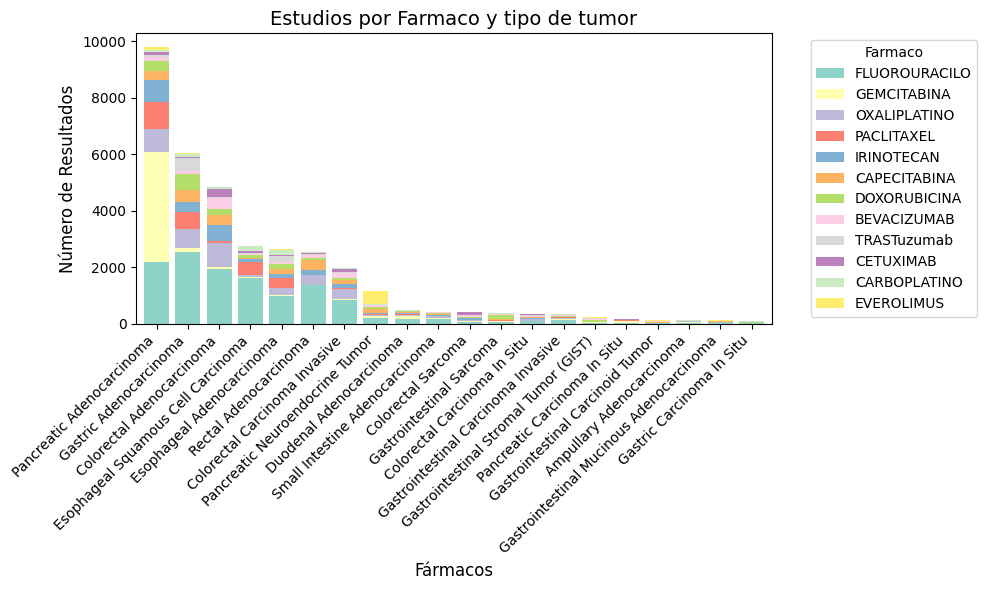

In [21]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor

# Configura la paleta de colores única para cada fármaco con Seaborn
colors = sns.color_palette("Set3", n_colors=len(top_farmacos))

# Creamos un gráfico de barras apiladas
ax = results_df_wide.head(20).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

# Añadimos etiquetas y título
ax.set_xlabel('Fármacos', fontsize=12)
ax.set_ylabel('Número de Resultados', fontsize=12)
ax.set_title('Estudios por Farmaco y tipo de tumor', fontsize=14)
ax.legend(title='Farmaco', bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda a la derecha
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()

In [ ]:
# Inicializar una lista para almacenar los resultados
results_list = []
adverseEffects = ["sarcopenia", "dysphagia"]

# Bucle anidado para combinar efecto adverso y fármacos
for adverseEffect in adverseEffects:
    for farmaco in farmacos['Farmaco']:
        # Crear la consulta combinando el tipo de tumor y el fármaco
        query = f"{adverseEffect} AND {farmaco}"
        # Obtener el número de resultados
        results_count = get_results_count(query)
        # Agregar los resultados a la lista
        results_list.append({'Efecto adverso': adverseEffect, 'Farmaco': farmaco, 'Resultados': results_count})

# Crear un DataFrame a partir de la lista de resultados
results_df = pd.DataFrame(results_list)

In [17]:
#Salvar resultados de la búsqueda en pubmed en .csv
results_df.to_csv('resultados_pubmed_efectos_adversos.csv', index=False)

In [13]:
#Cargar datos de los efectos adversos en la bibliografía
results_df = pd.read_csv("resultados_pubmed_efectos_adversos.csv")
results_df

,Efecto adverso,Farmaco,Resultados
0,sarcopenia,pembrolizumab,12
1,sarcopenia,osimertinib,0
2,sarcopenia,nivolumab,16
3,sarcopenia,abemaciclib,1
4,sarcopenia,emtansine trastuzumab,0
...,...,...,...
123,dysphagia,alpelisib,1
124,dysphagia,rucaparib,0
125,dysphagia,temozolomide,3
126,dysphagia,oxaliplatin,36


In [14]:
#Preprocesamieto del dataframe

# Utilizamos la función pivot_table (gestiona duplicados) para convertir el DataFrame largo a uno ancho
results_df_wide = results_df.pivot_table(index='Farmaco', columns='Efecto adverso', values='Resultados')

#Se elimina la etiqueta farmaco como nombre de columna
results_df_wide.columns.name = None

#Se resetea los indices para que Tipo de tumor y los nombres de los farmacos esten al mismo nivel
results_df_wide.reset_index(inplace=True)

#Se extraen los 25 farmacos con mayor número de resultados en la bibliografía. Independientemente del tipo de tumor 
top_farmacos = results_df_wide.drop(columns=['Farmaco']).sum().sort_values(ascending=False).head(12)

#Filtra el dataframe para quedarte solo con la columna de tipo de tumor y los farmacos con más resultados
results_df_wide = results_df_wide[['Farmaco'] + list(top_farmacos.index)]

#Define el tipo de tumor como los indices del dataframe
results_df_wide.set_index('Farmaco', inplace=True)

# Suma el total de resultados de los 15 fármacos para cada tipo de tumor y crea una nueva columna llamada 'TotalResultados'
results_df_wide['TotalResultados'] = results_df_wide[list(top_farmacos.index)].sum(axis=1)

# Ordena el DataFrame por la nueva columna 'TotalResultados' en orden descendente
results_df_wide = results_df_wide.sort_values(by='TotalResultados', ascending=False).reset_index()
results_df_wide = results_df_wide[['Farmaco'] + list(top_farmacos.index)]
results_df_wide.set_index('Farmaco', inplace=True)

results_df_wide

,dysphagia,sarcopenia
Farmaco,,
fluorouracil,325,42
paclitaxel,107,24
carboplatin,111,16
doxorubicin,86,28
sodium chloride,70,4
...,...,...
olaparib,0,0
deruxtecan trastuzumab,0,0
emtansine trastuzumab,0,0


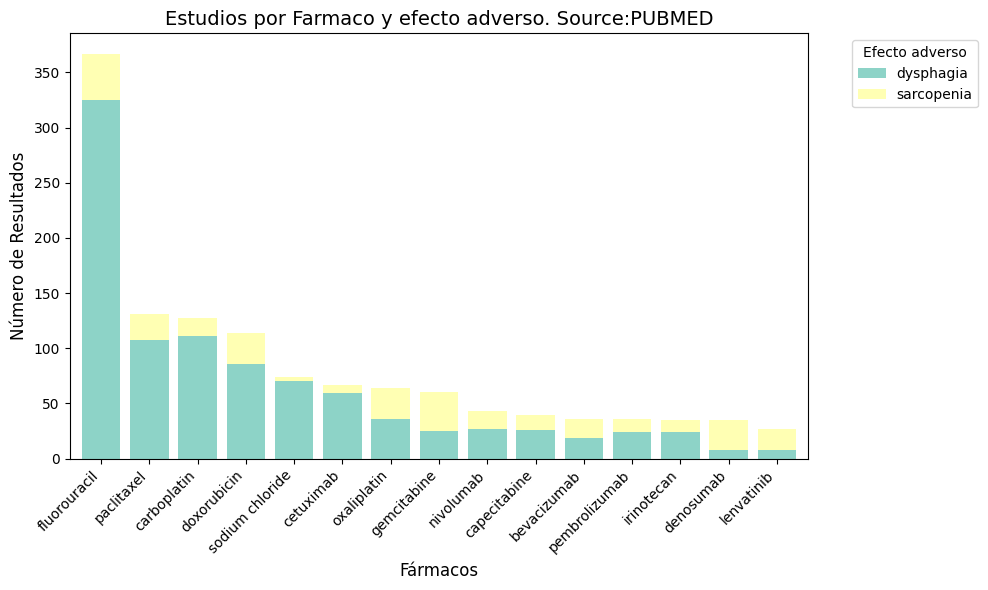

In [18]:
# Visualizar los resultados de cada farmaco en función del tipo de tumor

# Configura la paleta de colores única para cada fármaco con Seaborn
colors = sns.color_palette("Set3", n_colors=len(top_farmacos))

# Creamos un gráfico de barras apiladas
ax = results_df_wide.head(15).plot(kind='bar', stacked=True, figsize=(10, 6), color = colors, width=0.8)

# Añadimos etiquetas y título
ax.set_xlabel('Fármacos', fontsize=12)
ax.set_ylabel('Número de Resultados', fontsize=12)
ax.set_title('Estudios por Farmaco y efecto adverso. Source:PUBMED', fontsize=14)
ax.legend(title='Efecto adverso', bbox_to_anchor=(1.05, 1), loc='upper left')  # Colocar la leyenda a la derecha
plt.xticks(rotation=45, ha='right')  # Rotar las etiquetas del eje x
plt.tight_layout()  # Ajustar el diseño del gráfico
plt.show()